# Model Comparisons

In [18]:
# General imports
import os
import sys
import glob
from pathlib import Path
from datetime import datetime

# Custom Functions
sys.path.append(os.path.abspath('../Notebooks/Utilities')) 
import cust_utilities as utils

# Maths, Pandas etc
import math
import numpy as np
import pandas as pd
import scipy as sci

# Plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
# Get all the model evaluation run resuls and combine into a single df
#

data_folder_path = utils.get_folder_path('Model Comparisons')
file_name_pattern = '**/models_results_df**.pkl'
data_files = glob.glob(str(Path(data_folder_path) / file_name_pattern), recursive=True)

df_list = []
for next_file in data_files:
    df = pd.read_pickle(next_file, compression='zip')
    df_list.append(df)
models_evaluations_df = pd.concat(df_list, ignore_index=True)


In [ ]:
# Explore the structure of the combined dataframe
print("Dataframe shape:", models_evaluations_df.shape)
display(models_evaluations_df.head())

## Export

In [3]:
# Export The Entire DF to CSV

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
csv_filename = f"Model_Comparisons_DF_{timestamp}.csv"
csv_filepath = os.path.join(data_folder_path, csv_filename)
if os.path.exists(csv_filepath):
    raise FileExistsError(f'File Exists: {csv_pilepath}')

models_evaluations_df.to_csv(csv_filepath, index=False)

print(f"Successfully exported to CSV: {csv_filename}")
print(f"Total rows exported: {len(models_evaluations_df)}")
print(f"File location: {csv_filepath}")

Successfully exported to CSV: Model_Comparisons_DF_20250813_2043.csv
Total rows exported: 33
File location: /Users/stuartgow/GitHub/EEG_ML_Pipeline/Data/Model Comparisons/Model_Comparisons_DF_20250813_2043.csv


In [ ]:
# Export the combined dataframe to Excel
#

# Create filename with timestamp
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
excel_filename = f"model_comparisons_{timestamp}.xlsx"
excel_filepath = Path(data_folder_path) / excel_filename

try:
    # Export to Excel with multiple sheets
    with pd.ExcelWriter(excel_filepath, engine='openpyxl') as writer:
        # Main data sheet
        models_evaluations_df.to_excel(writer, sheet_name='All_Model_Results', index=False)
        
        # Summary statistics sheet (if we have the required columns)
        if 'model_name' in models_evaluations_df.columns:
            summary_stats = models_evaluations_df.groupby('model_name').agg({
                col: ['count', 'mean', 'std', 'min', 'max'] 
                for col in models_evaluations_df.select_dtypes(include=[np.number]).columns
            }).round(4)
            
            # Flatten column names
            summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]
            summary_stats.to_excel(writer, sheet_name='Summary_Statistics')
            
            # Model comparison sheet (key metrics only)
            if all(col in models_evaluations_df.columns for col in ['mcc', 'recall', 'precision', 'f1_score']):
                key_metrics = models_evaluations_df.groupby('model_name')[['mcc', 'recall', 'precision', 'f1_score']].agg(['mean', 'std']).round(4)
                key_metrics.columns = ['_'.join(col).strip() for col in key_metrics.columns.values]
                key_metrics.to_excel(writer, sheet_name='Key_Metrics_Comparison')
    
    print(f"✅ Successfully exported to: {excel_filepath}")
    print(f"📊 Total rows exported: {len(models_evaluations_df)}")
    print(f"📁 File location: {excel_filepath}")
    
except Exception as e:
    print(f"❌ Error exporting to Excel: {e}")
    print("Attempting basic export...")
    
    # Fallback: simple export
    try:
        models_evaluations_df.to_excel(excel_filepath, index=False)
        print(f"✅ Basic export successful: {excel_filepath}")
    except Exception as e2:
        print(f"❌ Basic export also failed: {e2}")

# Importance & Topographic Map

In [ ]:
# Load SHAP importance CSV file into a df
data_folder_path = utils.get_folder_path('Model Comparisons')
shap_csv_pattern = '**/shap_importance_df**.csv'
shap_files = glob.glob(str(Path(data_folder_path) / shap_csv_pattern), recursive=True)
df = pd.read_csv(shap_files[0])

# Keep just CF_0 rows
cf_df = df[df['feature'].str.contains('_cf_0', na=False)].copy()

# Strip 'numeric_channel_' prefix and cf
if 'feature' in cf_df.columns:
    cf_df['feature'] = cf_df['feature'].str.replace('numeric__channel_', '', regex=False)
    cf_df['feature'] = cf_df['feature'].str.replace('_cf_0', '', regex=False)


In [7]:
# Example data structure
electrode_data = {
    'electrode': ['O2', 'PO8', 'P6', 'P7', 'CP4'],
    'importance': [9.97, 8.37, 6.55, 5.82, 4.91]
}
df = pd.DataFrame(electrode_data)


In [ ]:
# Load standard montage
import mne
montage = mne.channels.make_standard_montage('standard_1020')

# Verify electrode coverage
available_electrodes = set(montage.ch_names)
# target_electrodes = set(df['electrode'])
target_electrodes = set(cf_df['feature'])
coverage = target_electrodes.intersection(available_electrodes)
print(f"Coverage: {len(coverage)}/{len(target_electrodes)} electrodes")



Coverage: 64/64 electrodes


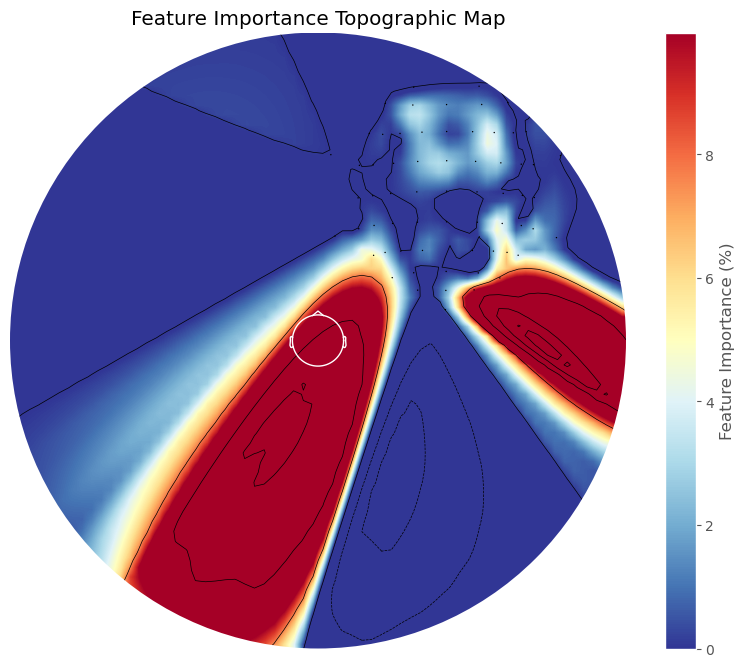

In [34]:
# electrode_list = df['electrode'].tolist()
# importance_values = df['importance'].values

electrode_list = cf_df['feature'].tolist()
importance_values = cf_df['importance_%'].values

# Create info object
info = mne.create_info(
    ch_names=electrode_list,
    sfreq=1000,  # Dummy sampling frequency
    ch_types='eeg'
)
info.set_montage(montage)
# Extract electrode positions for topographic plotting
pos = mne.find_layout(info).pos

# Generate topographic map
fig, ax = plt.subplots(figsize=(10, 8))
im, _ = mne.viz.plot_topomap(
    data=importance_values,
    pos=pos,  # Use positions instead of info
    axes=ax,
    cmap='RdYlBu_r',
    contours=6,
    show=False
)
# Enhance visualization
ax.set_title('Feature Importance Topographic Map')
plt.colorbar(im, label='Feature Importance (%)')
plt.show()